In [3]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
def masked_softmax(X, valid_lens):
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = _sequence_mask(
            X.reshape(-1, shape[-1]), valid_lens,
            value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [7]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5617, 0.4383, 0.0000, 0.0000],
         [0.6905, 0.3095, 0.0000, 0.0000]],

        [[0.2018, 0.4658, 0.3324, 0.0000],
         [0.4201, 0.2194, 0.3606, 0.0000]]])

In [8]:
masked_softmax(torch.rand(2, 2, 4),
               torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2652, 0.4217, 0.3131, 0.0000]],

        [[0.6100, 0.3900, 0.0000, 0.0000],
         [0.3152, 0.3162, 0.2098, 0.1588]]])

In [11]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [16]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))

valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 0.2157, -0.4344, -0.5320,  0.5619]],

        [[ 0.1400, -0.0852, -0.3779,  0.3336]]], grad_fn=<BmmBackward0>)

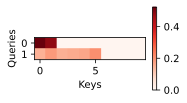

In [17]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),  xlabel='Keys', ylabel='Queries')

In [18]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2) / math.sqrt(d))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [21]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 0.7490,  0.0459, -0.6182,  0.4798]],

        [[ 0.0358, -0.1158, -0.3652,  0.3133]]])

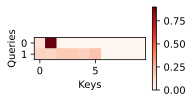

In [22]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')